# Code Concepts User Study

### Setup

In [189]:
#!pip install bertviz
#!pip uninstall bertviz

In [190]:
#!pip install python-igraph
#!pip uninstall python-igraph

In [191]:
#!pip install plotly
#!pip uninstall plotly

In [192]:
!pip install ipympl
!pip install networkx
!pip install mplcursors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Imports

In [193]:
#ENCAPSULED
import matplotlib.pyplot as plt
import networkx as nx
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
from statistics import mean
from CodeSyntaxConcept.tokenizer import CodeTokenizer
from CodeSyntaxConcept.parser import TreeSitterParser
import CodeSyntaxConcept.utils as utils
import mplcursors
import random

### Parameters

In [194]:
# specify a checkpoint to use, Transformer based text generation model (GPT)
# https://huggingface.co/models?other=text%20generation 
checkpoint = 'EleutherAI/gpt-neo-1.3B'
#checkpoint = 'EleutherAI/gpt-neo-125M'

In [195]:
########QUESTION TYPE 1
#S1
#prompt = '## Counts the number of occurences for the given \n## character in the provided string\ndef countCharts(string, character):\n    """Naive count charts"""\n    count = 0\n    for letter in character.lower():\n        if isletter(letter):\n       '
#S2
#prompt = '# Linearly search x in arr[]\n# If x is present then return its location\n# else return -1\ndef search(arr, x):\n    for i in ran:\n        if arr[i] == x:\n            return i\n    return -1\n\n# This is a more efficient version of search\n'
#S5
#prompt = '# Recursive Python function to solve tower of hanoi  \ndef TowerOfHanoi(n, from_rod, to_rod, aux_rod):\n    if n == 0:\n        return\n    TowerOfHanoi(n, from_rod, to_rod, np.zeros(n))\n    for p in [0,1]:\n        if p == 1:\n            return\n'
#S8
#prompt = '## Checks if the given number is prime and returns True or False\ndef is_prime(num)\n    p = 0\n    for i in range(2, 9):\n        if i <= num % i:\n            return False\n        p += i\n    return True'

In [196]:
########QUESTION TYPE 2
#S3
#prompt = '# A Naive recursive Python implementation of LCS problem\ndef lcs(X, Y, m, n):\n    if m == 0 or n == 0:\n       return 0\n    elif X[m-1]!= Y[n-1]: # x < X[m-1]\n       return lcs(X, Y, m-1, n-1) + lcs(X, Y, m-1, n)\n    elif Y[n]'
#S4
#prompt = 'from collections import defaultdict\n#merge two or more dicts using the collections module\ndef merge_dicts(*dicts):\n    mdict = defaultdict(list)\n    for d in dicts:\n        for key in d:\n            mdict[key].append(d[key])\nreturn dict(mdict)'
#S6
#prompt = 'def bubbleSort(arr):\n    n = len(arr)\n    swapped = False\n    # Traverse through all array elements\n    for i in range(n-1):\n        for j in range(n-1):\n            if arr[i] < arr[j]:\n                swapped = True\n            if arr[j] > arr[i]:\n                swapped = False\n\n        if swapped:\n            arr.sort()\n\n    swapped = False\n    # Now, see if we have any match\n'
#S7
prompt = 'def merge(*args, missing_val = None):\n    #missing_val will be used when one of the smaller lists is shorter tham the others.\n    #Get the maximum length within the smaller lists.\n    max_length = max([len(lst) for lst in args])\n    outList = []\n    for i in range(max_length):\n        result.append([args[k][i] if i < len(args[k]) else missing_val for k in range(len(args))])\n    return outList'

In [197]:
# programming language of the snippet.
language = "python"

### Processing

In [198]:
# ENCAPSULTED
text_generator_pipe = pipeline(task='text-generation', model=checkpoint)
text_generator_model = AutoModelForCausalLM.from_pretrained(checkpoint)
text_generator_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [199]:
# ENCAPSULTED
#encode
encoded_input = text_generator_tokenizer.encode_plus(prompt, return_tensors='pt', return_offsets_mapping=True)
#generates the original sequence (forward)
encoded_output = text_generator_model(encoded_input['input_ids'])
#encoded_output = text_generator_model.generate(**encoded_input, pad_token_id=text_generator_tokenizer.eos_token_id, max_length=len(encoded_input['input_ids'][0])+10, output_scores=True, return_dict_in_generate=True)
sequence_index = 0 # just 1 snippet

In [200]:
# ENCAPSULATED
## Actual probability case
def get_actual_probs(encoded_output, encoded_input ,sequence_index, text_generator_tokenizer):
    output_probs = encoded_output['logits'][sequence_index].softmax(dim=0)
    vocabulary_indexes = list(text_generator_tokenizer.get_vocab().values())
    vocabulary_values = list(text_generator_tokenizer.get_vocab().keys())
    sequence = []
    for input_id_index, input_id in enumerate(encoded_input['input_ids'][sequence_index]): ## Eliminate first token
        input_id_location = vocabulary_indexes.index(encoded_input['input_ids'][sequence_index][input_id_index].item())
        input_id_pred_prob = output_probs[input_id_index][input_id_location]
        #sequence.append((input_id.item(), input_id_pred_prob.item()))
        sequence.append((vocabulary_values[input_id_location], input_id_pred_prob.item()))
    return sequence


In [201]:
# ENCAPSULATED 
## Binds tree with actual probabilities
def bind_bpe_tokens(
    node,              #Tree sitter ast tree
    encodings,          #Token encoding
    actual_probs,      #Actual probabilities
    lines              #Source code Snippet
): 
    """Traverses the tree and bind the leaves with the corresponding node"""
    tree_node = {}
    tree_node['type'] = node.type
    tree_node['children'] = []
    tree_node['bindings'] = []
    tree_node['prob'] = 0

    node_span = [utils.convert_to_offset(node.start_point, lines), utils.convert_to_offset(node.end_point, lines)]

    for encoding_index, token_span in enumerate(encodings):
        if (node_span[0] <= token_span[0] and token_span[0] < node_span[1]) \
        or (node_span[0] < token_span[1] and token_span[1] <= node_span[1]) \
        or (node_span[0] >= token_span[0] and token_span[1] >= node_span[1]) :
            tree_node['bindings'].append(actual_probs[encoding_index])
    
    for n in node.children:
        tree_node['children'].append(bind_bpe_tokens(n, encodings, actual_probs, lines))
    
    tree_node['prob'] = mean([prob for element, prob in tree_node['bindings']])

    return tree_node
        

In [202]:
# ENCAPSULATED
def create_graph_from_binded_tree(binded_tree):

    def build_graph(graph, binded_ast_node, parent_node_id, labels, attributes):
        node_id = len(graph)
        graph.add_node(node_id)
        attributes[node_id] = {'type': binded_ast_node['type'], 'degree': len(binded_ast_node['children']) + 1, 'prob': binded_ast_node['prob'], 'tokens': [element for element, prob in binded_ast_node['bindings']]}
        labels[node_id] = binded_ast_node['type']
        if parent_node_id is not None:
            graph.add_edge(parent_node_id, node_id)     
        for child in binded_ast_node['children']:
            build_graph(graph, child, node_id, labels, attributes)
    graph = nx.DiGraph()
    labels = {}
    attributes = {}
    build_graph(graph, binded_tree, None, labels, attributes)
    return graph, labels, attributes

In [203]:
# ENCAPSULATED
def create_linear_representation_from_probs(actual_probs):
    graph = nx.DiGraph()
    labels = {}
    attributes = {}
    parent_node_id = 0
    for token in actual_probs:
        node_id = len(graph)
        graph.add_node(node_id)
        attributes[node_id] = {'prob': token[1]}
        labels[node_id] = token[0]
        if node_id != 0:
            graph.add_edge(parent_node_id, node_id)
        parent_node_id = node_id
    return graph, labels, attributes

In [204]:
# ENCAPSULATED
## Asociate BPE tokens with terminals
concepts_tokenizer = CodeTokenizer.from_pretrained(checkpoint, language)
actual_probs = get_actual_probs(encoded_output, encoded_input ,sequence_index, text_generator_tokenizer)
tree = concepts_tokenizer.parser.parse(bytes(prompt, "utf8"))
binded_tree = bind_bpe_tokens(tree.root_node, encoded_input['offset_mapping'][sequence_index].tolist(), actual_probs, prompt.split('\n'))

In [205]:
actual_probs

[('def', 0.2660728394985199),
 ('Ġbubble', 0.014193142764270306),
 ('Sort', 1.537986463517882e-06),
 ('(', 1.556356619403232e-05),
 ('arr', 3.13795026158914e-05),
 ('):', 1.3370040505833458e-06),
 ('Ċ', 1.8573391571408138e-06),
 ('Ġ', 0.00035610824124887586),
 ('Ġ', 0.00012616821913979948),
 ('Ġ', 0.0036348786670714617),
 ('Ġn', 0.00012029817298753187),
 ('Ġ=', 0.014171173796057701),
 ('Ġlen', 1.0545464647293556e-05),
 ('(', 1.069861994551502e-07),
 ('arr', 1.0770868357212748e-06),
 (')', 3.598575304408769e-08),
 ('Ċ', 1.3714842452827725e-06),
 ('Ġ', 2.0712413970613852e-05),
 ('Ġ', 1.171051280834945e-06),
 ('Ġ', 0.003655221313238144),
 ('Ġswapped', 6.357047095661983e-05),
 ('Ġ=', 0.015504375100135803),
 ('ĠFalse', 1.1887134860444348e-05),
 ('Ċ', 6.751680103889157e-08),
 ('Ġ', 4.133753009227803e-06),
 ('Ġ', 1.2697992701760086e-07),
 ('Ġ', 0.0011968007311224937),
 ('Ġ#', 0.0849822461605072),
 ('ĠTra', 3.543007915141061e-05),
 ('verse', 0.00020350403792690486),
 ('Ġthrough', 0.00061278417

### Visualize

In [206]:
# ENCAPSULATED
def hierarchy_pos(G, root=None, width=4., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5):
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')
    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))
        else:
            root = random.choice(list(G.nodes))
    def _hierarchy_pos(G, root, width=4., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap,
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [207]:
def horizontal_layout(graph: nx.DiGraph):
    pos = {}
    for node_idx in range(graph.number_of_nodes()):
        pos[node_idx] = (node_idx, 0)
    return pos

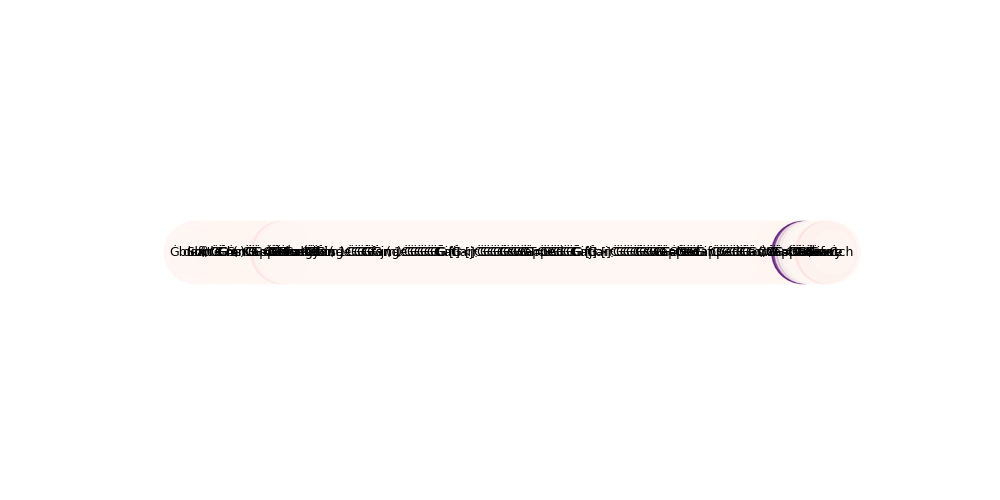

In [210]:
%matplotlib widget

graph, labels, attributes = create_linear_representation_from_probs(actual_probs)
nx.set_node_attributes(graph, attributes)

#pos = nx.arf_layout(graph)
#pos = nx.circular_layout(graph)
#pos = hierarchy_pos(graph,0)
#pos = nx.planar_layout(graph)
#pos = nx.spectral_layout(graph)
#pos = nx.kamada_kawai_layout(graph, dim=0)
#pos = nx.spring_layout(graph)
pos = horizontal_layout(graph)
 
node_color = [nx.get_node_attributes(graph, 'prob')[v] for v in graph]
node_size = [graph.degree(v)*1000 for v in graph]

nodes = nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=node_color, cmap = plt.cm.RdPu, alpha = 0.7)
nx.draw_networkx_labels(graph, pos, font_color='black', labels=labels, font_size=9)
nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), edge_color='.4', width=1)

def update_annot(sel):
    node_index = sel.target.index
    node_name = list(graph.nodes)[node_index]
    node_attr = graph.nodes[node_name]
    text = 'prob: ' + str(round(node_attr['prob'],7))
    sel.annotation.set_text(text)

cursor = mplcursors.cursor(nodes)
cursor.connect('add', update_annot)


plt.rcParams["figure.figsize"] = (10,5)
plt.axis("off")
plt.show()

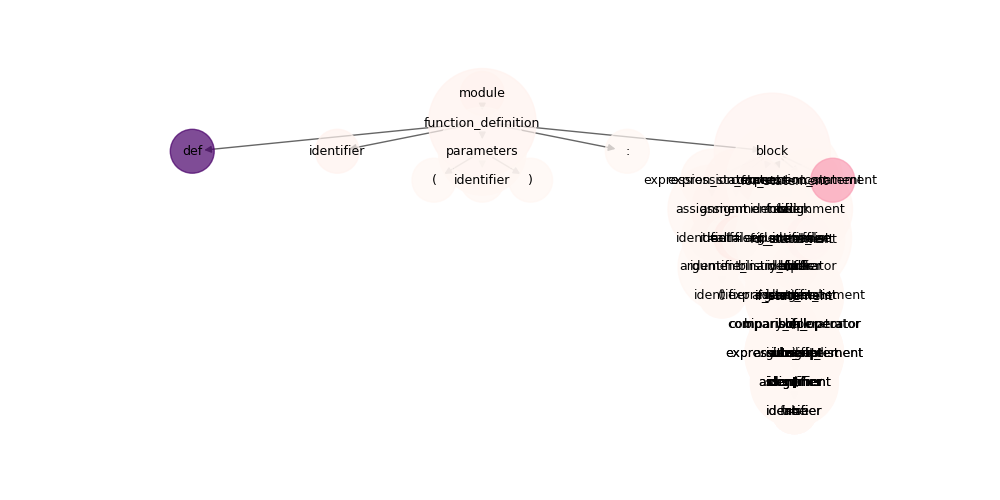

/home/svelascodimate/miniconda3/envs/code-syntax-concept/lib/python3.10/site-packages/mplcursors/_pick_info.py:142: UserWarning: Selection.target.index is deprecated and will be removed in the future; use Selection.index instead.
  warnings.warn(


In [209]:
%matplotlib widget

graph, labels, attributes = create_graph_from_binded_tree(binded_tree)
nx.set_node_attributes(graph, attributes)

#pos = nx.arf_layout(graph)
#pos = nx.circular_layout(graph)
pos = hierarchy_pos(graph, 0)
#pos = nx.planar_layout(graph)
#pos = nx.spectral_layout(graph)

node_color = [nx.get_node_attributes(graph, 'prob')[v] for v in graph]
node_size = [graph.degree(v)*1000 for v in graph]

nodes = nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=node_color, cmap = plt.cm.RdPu, alpha = 0.7)
nx.draw_networkx_labels(graph, pos, font_color='black', labels=labels, font_size=9)
nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), edge_color='.4', width=1)

def update_annot(sel):
    node_index = sel.target.index
    node_name = list(graph.nodes)[node_index]
    node_attr = graph.nodes[node_name]
    text = 'prob: ' + str(round(node_attr['prob'],7)) + '\n' \
        + 'tokens: ' + str(node_attr['tokens'])
    sel.annotation.set_text(text)

cursor = mplcursors.cursor(nodes)
cursor.connect('add', update_annot)


plt.rcParams["figure.figsize"] = (10,5)
plt.axis("off")
plt.show()